### Optimal control of the ALN model
This notebook shows how to compute the optimal control (OC) signal for the ALN model for a simple example task.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

while os.getcwd().split(os.sep)[-1] != "neurolib":
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.aln import ALNModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.control.optimal_control import oc_aln
from neurolib.control.optimal_control.oc_utils.plot_oc import plot_oc_singlenode, plot_oc_network

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2


# This function reads out the final state of a simulation
def getfinalstate(model):
    N = model.params.Cmat.shape[0]
    V = len(model.state_vars)
    T = model.getMaxDelay() + 1
    state = np.zeros((N, V, T))
    for v in range(V):
        if "rates" in model.state_vars[v] or "IA" in model.state_vars[v]:
            for n in range(N):
                state[n, v, :] = model.state[model.state_vars[v]][n, -T:]
        else:
            for n in range(N):
                state[n, v, :] = model.state[model.state_vars[v]][n]
    return state


def setinitstate(model, state):
    N = model.params.Cmat.shape[0]
    V = len(model.init_vars)
    T = model.getMaxDelay() + 1

    for n in range(N):
        for v in range(V):
            if "rates" in model.init_vars[v] or "IA" in model.init_vars[v]:
                model.params[model.init_vars[v]] = state[:, v, -T:]
            else:
                model.params[model.init_vars[v]] = state[:, v, -1]

    return

def getstate(model):
    state = np.concatenate(  ( np.concatenate((model.params["rates_exc_init"][:, np.newaxis, -1],
                                            model.params["rates_inh_init"][:, np.newaxis, -1],
                                            model.params["IA_init"][:, np.newaxis, -1], ), axis=1, )[:, :, np.newaxis],
                            np.stack((model.rates_exc, model.rates_inh, model.IA), axis=1),),axis=2,  )
    
    return state

We stimulate the system with a known control signal, define the resulting activity as target, and compute the optimal control for this target. We define weights such that precision is penalized only (w_p=1, w_2=0). Hence, the optimal control signal should converge to the input signal.

We first study current inputs. We will later proceed to rate inputs.

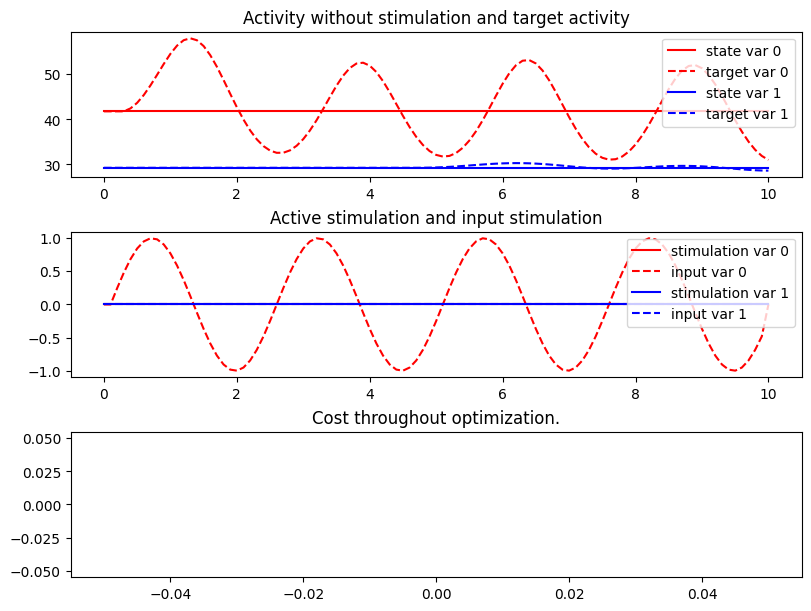

In [8]:
# We import the model
model = ALNModel()
model.params.duration = 10000
model.params.mue_ext_mean = 2. # up state
model.run()
setinitstate(model, getfinalstate(model))

# Some parameters to define stimulation signals
dt = model.params["dt"]
duration = 10.
amplitude = 1.
period = duration /4.

# We define a "zero-input", and a sine-input
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,1:-1] = amplitude * np.sin(2.*np.pi*np.arange(0,duration-0.1, dt)/period) # other functions or random values can be used as well

# We set the duration of the simulation and the initial values
model.params["duration"] = duration

# We set the stimulus in x and y variables, and run the simulation
model.params["ext_exc_current"] = input
model.params["ext_inh_current"] = zero_input
model.params["ext_exc_rate"] = zero_input
model.params["ext_inh_rate"] = zero_input

model.run()

# Define the result of the stimulation as target
target = getstate(model)
target_input = np.concatenate( (input, zero_input, zero_input, zero_input), axis=0)[np.newaxis,:,:]

# Remove stimuli and re-run the simulation
model.params["ext_exc_current"] = zero_input
model.params["ext_inh_current"] = zero_input
control = np.concatenate( (zero_input, zero_input, zero_input, zero_input), axis=0)[np.newaxis,:,:]
model.run()

# combine initial value and simulation result to one array
state = getstate(model)

plot_oc_singlenode(duration, dt, state, target, control, target_input)

Compute control for a deterministic system
Cost in iteration 0: 314.1247597247194
Cost in iteration 25: 0.13317432824531167
Cost in iteration 50: 0.025934764241784855
Cost in iteration 75: 0.010689714898934012
Cost in iteration 100: 0.006042649711908977
Cost in iteration 125: 0.003852074448389804
Cost in iteration 150: 0.0026454397557471756
Cost in iteration 175: 0.0019048498068881534
Cost in iteration 200: 0.0014175325285176437
Cost in iteration 225: 0.0010832777739798686
Cost in iteration 250: 0.0008270405756069322
Cost in iteration 275: 0.000647747907643482
Cost in iteration 300: 0.0005135789763737352
Cost in iteration 325: 0.00041166220430455887
Cost in iteration 350: 0.00033334319584000865
Cost in iteration 375: 0.0002682483135493626
Cost in iteration 400: 0.00021897331522083166
Cost in iteration 425: 0.0001797951466810639
Cost in iteration 450: 0.0001484385297291106
Cost in iteration 475: 0.00012322292996632452
Cost in iteration 500: 0.0001019978308262297
Final cost : 0.000101997

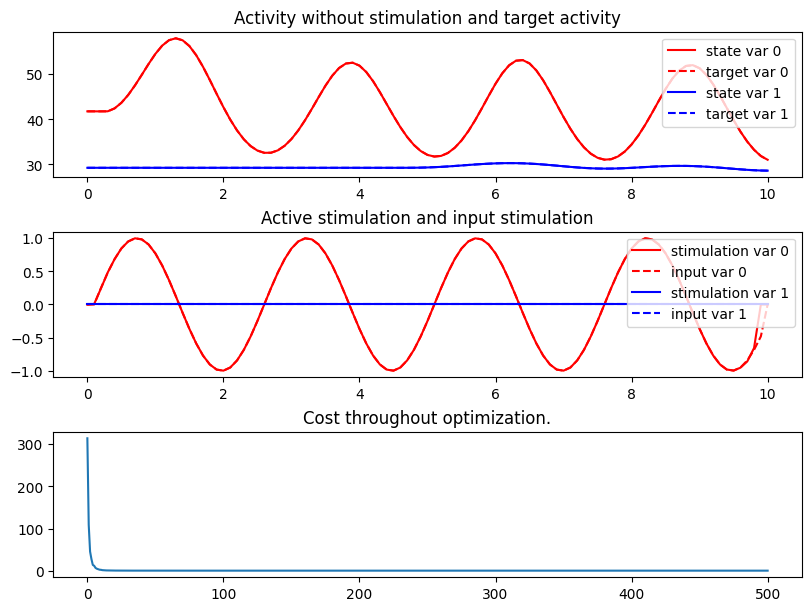

In [9]:
# We load the optimal control class
# print array (optional parameter) defines, for which iterations intermediate results will be printed
# Parameters will be taken from the input model
control_mat = np.zeros((1,len(model.input_vars)))
control_mat[0,0] = 1.
cost_mat = np.zeros((1,len(model.output_vars)))
cost_mat[0,0] = 1.

model_controlled = oc_aln.OcAln(model, target, print_array=np.arange(0,501,25), control_matrix=control_mat, cost_matrix=cost_mat)
model_controlled.weights["w_p"] = 1. # default value 1
model_controlled.weights["w_2"] = 0. # default value 0

# We run 500 iterations of the optimal control gradient descent algorithm
model_controlled.optimize(500)

state = model_controlled.get_xs()
control = model_controlled.control

plot_oc_singlenode(duration, dt, state, target, control, target_input, model_controlled.cost_history)

Compute control for a deterministic system
Cost in iteration 0: 0.0001019978308262297
Cost in iteration 25: 8.503577269809191e-05
Cost in iteration 50: 7.113629148054069e-05
Cost in iteration 75: 5.970536946996868e-05
Cost in iteration 100: 5.02763560369055e-05
Final cost : 5.02763560369055e-05


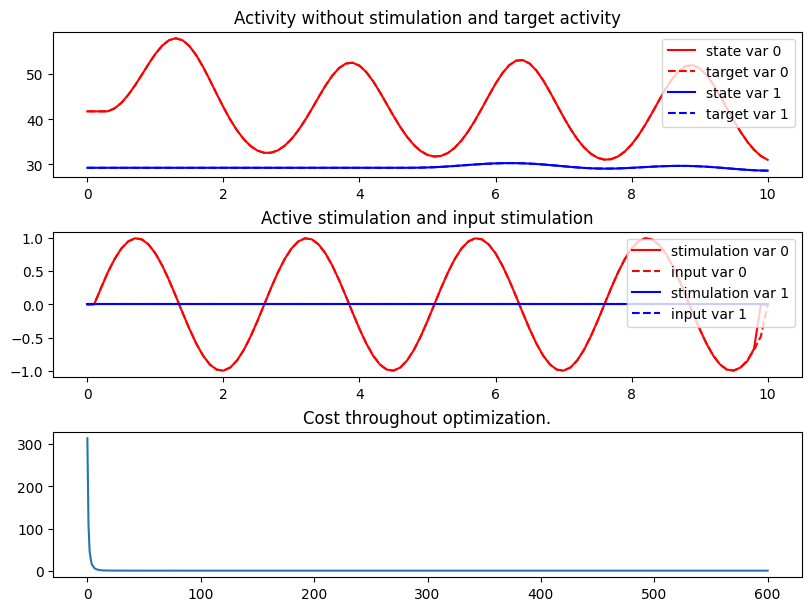

In [10]:
# Do another 100 iterations if you want to.
# Repeated execution will continue with further 100 iterations.
model_controlled.optimize(100)
state = model_controlled.get_xs()
control = model_controlled.control
plot_oc_singlenode(duration, dt, state, target, control, target_input, model_controlled.cost_history)

Let us now look at a scenario with rate-type control inputs

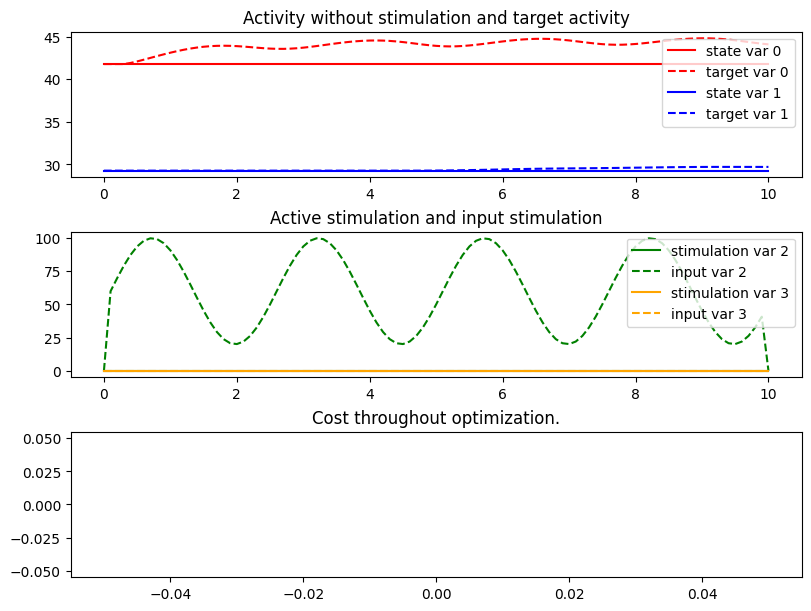

In [11]:
amplitude = 40.
offset = 60.
period = duration /4.

# We define a "zero-input", and a sine-input
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,1:-1] = offset + amplitude * np.sin(2.*np.pi*np.arange(0,duration-0.1, dt)/period) # other functions or random values can be used as well

# We set the stimulus in x and y variables, and run the simulation
model.params["ext_exc_current"] = zero_input
model.params["ext_inh_current"] = zero_input
model.params["ext_exc_rate"] = input * 1e-3 # rate inputs need to be converted to kHz
model.params["ext_inh_rate"] = zero_input

model.run()

# Define the result of the stimulation as target
target = getstate(model)
target_input = np.concatenate( (zero_input, zero_input, input, zero_input), axis=0)[np.newaxis,:,:]

# Remove stimuli and re-run the simulation
model.params["ext_exc_rate"] = zero_input
control = np.concatenate( (zero_input, zero_input, zero_input, zero_input), axis=0)[np.newaxis,:,:]
model.run()

# combine initial value and simulation result to one array
state = getstate(model)

plot_oc_singlenode(duration, dt, state, target, control, target_input, plot_control_vars=[2,3])

Compute control for a deterministic system
Cost in iteration 0: 27.349397232974408
Cost in iteration 25: 0.0006390076320320428
Cost in iteration 50: 0.00014311978667798868
Cost in iteration 75: 8.017957661471726e-05
Cost in iteration 100: 5.679617359217007e-05
Cost in iteration 125: 4.306794192661556e-05
Cost in iteration 150: 3.376433119895472e-05
Cost in iteration 175: 2.7066420641127278e-05
Cost in iteration 200: 2.2059610014723193e-05
Cost in iteration 225: 1.8212160897041168e-05
Cost in iteration 250: 1.5191277735291038e-05
Cost in iteration 275: 1.2778303406474285e-05
Cost in iteration 300: 1.0888696043551817e-05
Cost in iteration 325: 9.243703911351409e-06
Cost in iteration 350: 7.899581967191086e-06
Cost in iteration 375: 6.787562684851147e-06
Cost in iteration 400: 5.859013881863671e-06
Cost in iteration 425: 5.077487368901499e-06
Cost in iteration 450: 4.439379983051779e-06
Cost in iteration 475: 3.85899283693207e-06
Cost in iteration 500: 3.3690715490197364e-06
Final cost : 

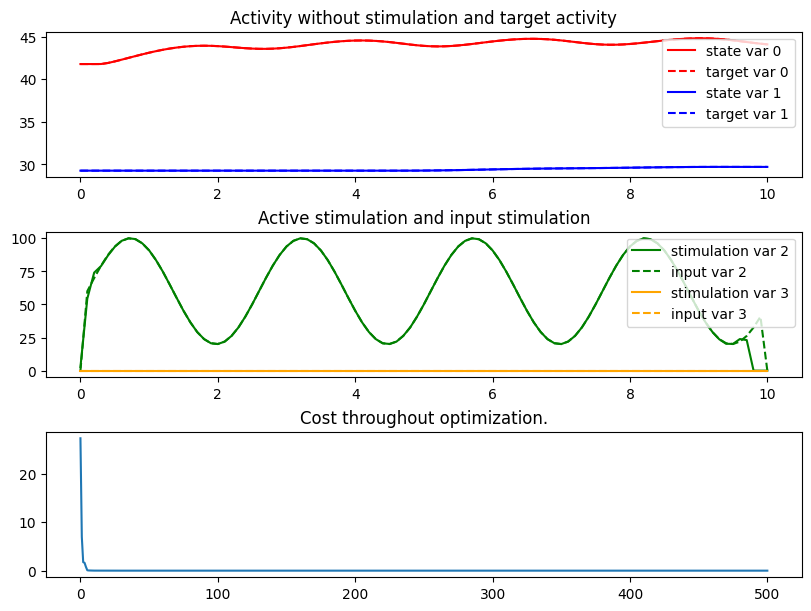

In [12]:
# Control matrix needs to be adjusted for rate inputs
control_mat = np.zeros((1,len(model.input_vars)))
control_mat[0,2] = 1.

model_controlled = oc_aln.OcAln(model, target, print_array=np.arange(0,501,25), control_matrix=control_mat, cost_matrix=cost_mat)
model_controlled.weights["w_p"] = 1. # default value 1
model_controlled.weights["w_2"] = 0. # default value 0

# We run 500 iterations of the optimal control gradient descent algorithm
model_controlled.optimize(500)

state = model_controlled.get_xs()
control = model_controlled.control

plot_oc_singlenode(duration, dt, state, target, control*1e3, target_input, model_controlled.cost_history, plot_control_vars=[2,3])

Compute control for a deterministic system
Cost in iteration 0: 3.3690715490197364e-06
Cost in iteration 25: 2.9515384676759174e-06
Cost in iteration 50: 2.593417209868494e-06
Cost in iteration 75: 2.2845622320483142e-06
Cost in iteration 100: 2.024231674713015e-06
Final cost : 2.024231674713015e-06


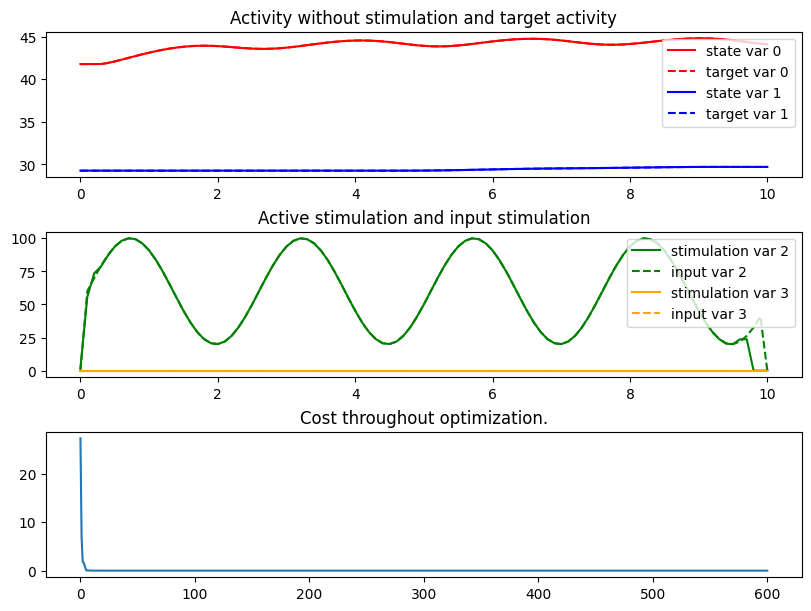

In [13]:
# Do another 100 iterations if you want to.
# Repeated execution will continue with further 100 iterations.
model_controlled.optimize(100)
state = model_controlled.get_xs()
control = model_controlled.control
plot_oc_singlenode(duration, dt, state, target, control*1e3, target_input, model_controlled.cost_history, plot_control_vars=[2,3])

### Network case

Let us know study a simple 2-node network of model oscillators. We first define the coupling matrix and the distance matrix. We can then initialize the model.

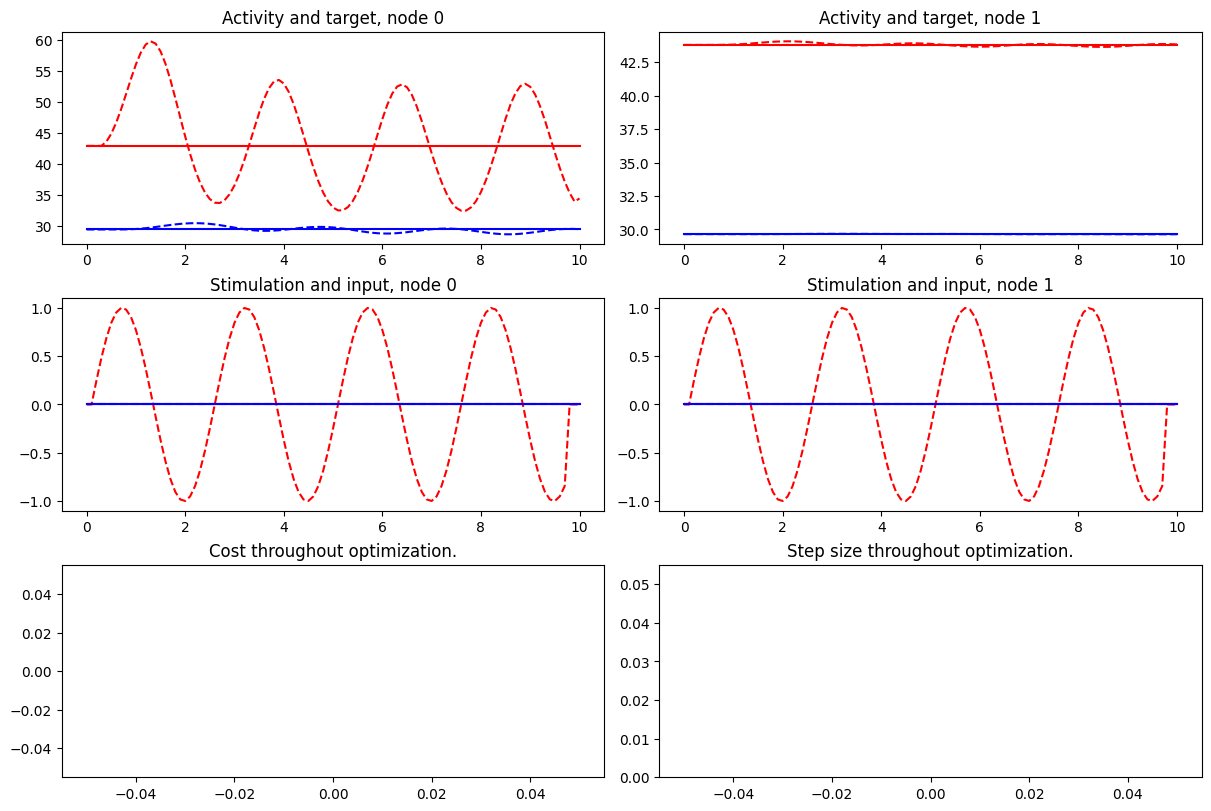

In [16]:
cmat = np.array( [[0., 0.5], [1., 0.]] )  # diagonal elements are zero, connection strength is 1 (0.5) from node 0 to node 1 (from node 1 to node 0)
dmat = np.array( [[0., 0.], [0., 0.]] )  # no delay

model = ALNModel(Cmat=cmat, Dmat=dmat)
model.params.duration = 10000
model.params.mue_ext_mean = 2. # up state
model.params.de = 0.0
model.params.di = 0.0
model.run()
setinitstate(model, getfinalstate(model))

# we define the control input matrix to enable or disable certain channels and nodes
control_mat = np.zeros( (model.params.N, len(model.input_vars)) )
control_mat[0,0] = 1. # only allow inputs in x-channel in node 0

amplitude = 1.
model.params["duration"] = duration
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,1:-3] = amplitude * np.sin(2.*np.pi*np.arange(0,duration-0.3, dt)/period) # other functions or random values can be used as well

# We set the stimulus in x and y variables, and run the simulation
input_nw = np.concatenate( (np.vstack( [control_mat[0,0] * input, control_mat[0,1] * input, control_mat[0,2] * input, control_mat[0,3] * input] )[np.newaxis,:,:],
                            np.vstack( [control_mat[1,0] * input, control_mat[1,1] * input, control_mat[1,2] * input, control_mat[1,3] * input] )[np.newaxis,:,:]), axis=0)
zero_input_nw = np.concatenate( (np.vstack( [zero_input, zero_input, zero_input, zero_input] )[np.newaxis,:,:],
                                 np.vstack( [zero_input, zero_input, zero_input, zero_input] )[np.newaxis,:,:]), axis=0)

model.params["ext_exc_current"] = input_nw[:,0,:]
model.params["ext_inh_current"] = input_nw[:,1,:]
model.params["ext_exc_rate"] = input_nw[:,2,:]
model.params["ext_inh_rate"] = input_nw[:,3,:]
model.run()

# Define the result of the stimulation as target
target = getstate(model)

# Remove stimuli and re-run the simulation
model.params["ext_exc_current"] = zero_input_nw[:,0,:]
model.params["ext_inh_current"] = zero_input_nw[:,1,:]
model.params["ext_exc_rate"] = zero_input_nw[:,2,:]
model.params["ext_inh_rate"] = zero_input_nw[:,3,:]
model.run()

# combine initial value and simulation result to one array
state = getstate(model)
plot_oc_network(model.params.N, duration, dt, state, target, zero_input_nw, input_nw)

Compute control for a deterministic system
Cost in iteration 0: 0.05681899553888795
Cost in iteration 25: 0.009049511507864006
Cost in iteration 50: 0.00385727901608276
Cost in iteration 75: 0.0018622667677526768
Cost in iteration 100: 0.000987085765866294
Cost in iteration 125: 0.000572356512723035
Cost in iteration 150: 0.0003547474327963845
Cost in iteration 175: 0.0002363751625995732
Cost in iteration 200: 0.0001619919185800181
Cost in iteration 225: 0.00011952382655835105
Cost in iteration 250: 9.020890267478555e-05
Cost in iteration 275: 7.169979753138072e-05
Cost in iteration 300: 5.8948947006216384e-05
Cost in iteration 325: 4.953649496402098e-05
Cost in iteration 350: 4.2578616654798227e-05
Cost in iteration 375: 3.721358584763165e-05
Cost in iteration 400: 3.294916084298363e-05
Cost in iteration 425: 2.9490826042506942e-05
Cost in iteration 450: 2.6637122691294857e-05
Cost in iteration 475: 2.418022517349344e-05
Cost in iteration 500: 2.213935579529806e-05
Final cost : 2.2139

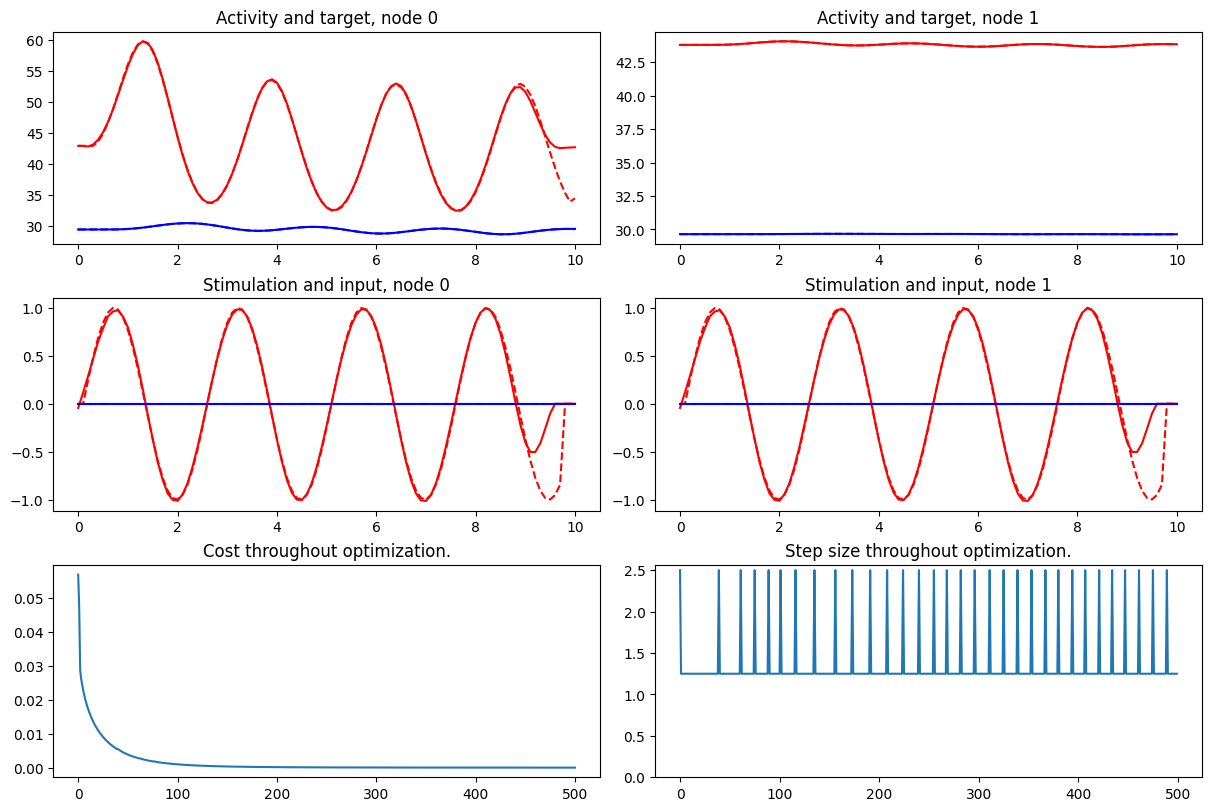

In [17]:
# we define the precision matrix to specify, in which nodes and channels we measure deviations from the target
cost_mat = np.zeros( (model.params.N, len(model.output_vars)) )
cost_mat[1,0] = 1. # only measure in y-channel in node 1

# We set the external stimulation to zero. This is the "initial guess" for the OC algorithm
model.params["ext_exc_current"] = zero_input_nw[:,0,:]
model.params["ext_inh_current"] = zero_input_nw[:,1,:]
model.params["ext_exc_rate"] = zero_input_nw[:,2,:]
model.params["ext_inh_rate"] = zero_input_nw[:,3,:]

# We load the optimal control class
# print array (optional parameter) defines, for which iterations intermediate results will be printed
# Parameters will be taken from the input model
model_controlled = oc_aln.OcAln(model, target, print_array=np.arange(0,501,25), control_matrix=control_mat, cost_matrix=cost_mat)

# We run 500 iterations of the optimal control gradient descent algorithm
model_controlled.optimize(500)

state = model_controlled.get_xs()
control = model_controlled.control

plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)

Compute control for a deterministic system
Cost in iteration 0: 2.213935579529806e-05
Cost in iteration 100: 1.6372947909519095e-05
Cost in iteration 200: 1.2839061879178726e-05
Cost in iteration 300: 1.0476920392110899e-05
Cost in iteration 400: 8.809334792766664e-06
Cost in iteration 500: 7.579247993018956e-06
Cost in iteration 600: 6.639612610095032e-06
Cost in iteration 700: 5.901347494253338e-06
Cost in iteration 800: 5.307170031237666e-06
Cost in iteration 900: 4.818470016522556e-06
Cost in iteration 1000: 4.4122066240398455e-06
Cost in iteration 1100: 4.062474402520346e-06
Cost in iteration 1200: 3.7619507397689863e-06
Cost in iteration 1300: 3.5005556108866255e-06
Cost in iteration 1400: 3.27097763467494e-06
Cost in iteration 1500: 3.067439471695257e-06
Cost in iteration 1600: 2.886197862816384e-06
Cost in iteration 1700: 2.7242350084897392e-06
Cost in iteration 1800: 2.5774139284662165e-06
Cost in iteration 1900: 2.4441984503997927e-06
Cost in iteration 2000: 2.322432927414839

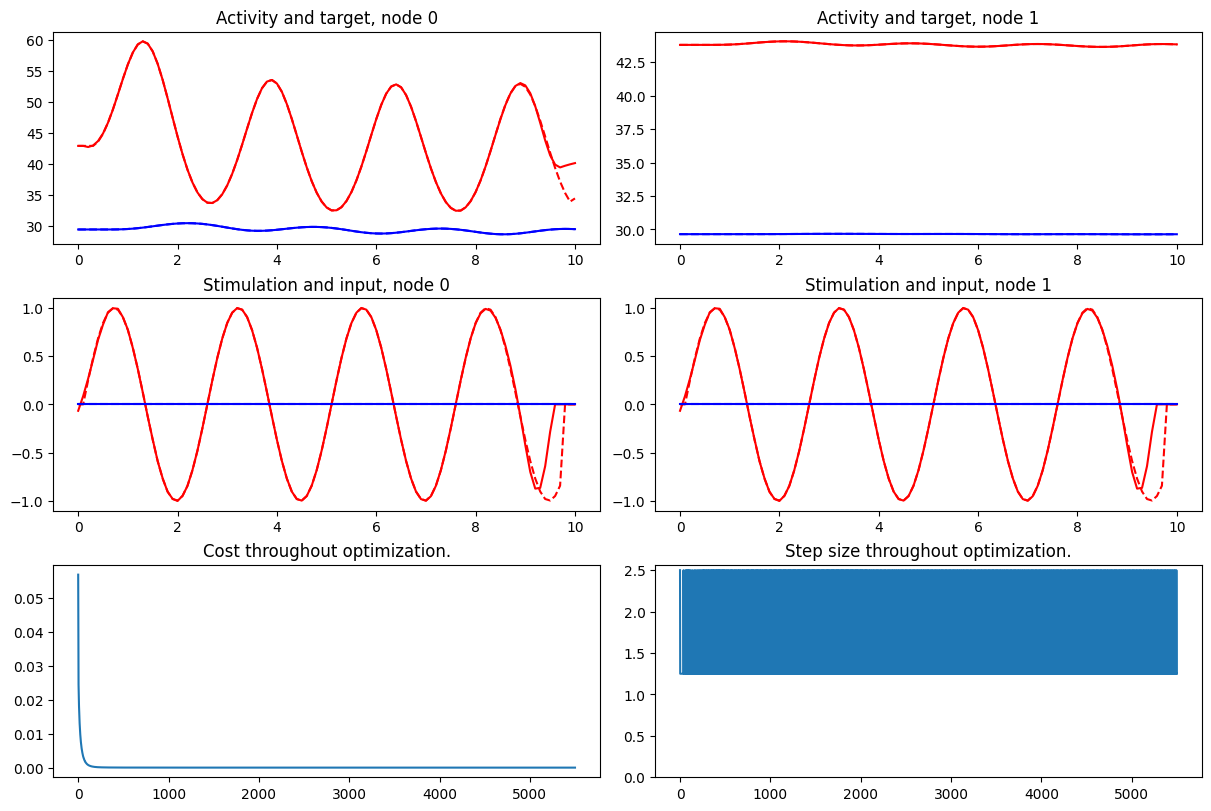

In [18]:
# Do another 1000 iterations if you want to.
# Repeated execution will continue with further 100 iterations.
model_controlled.zero_step_encountered = False
model_controlled.print_array = np.arange(0,5001,100)
model_controlled.optimize(5000)

state = model_controlled.get_xs()
control = model_controlled.control
plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)

### Delayed network of neural populations

We now consider a network topology with delayed signalling between the two nodes.

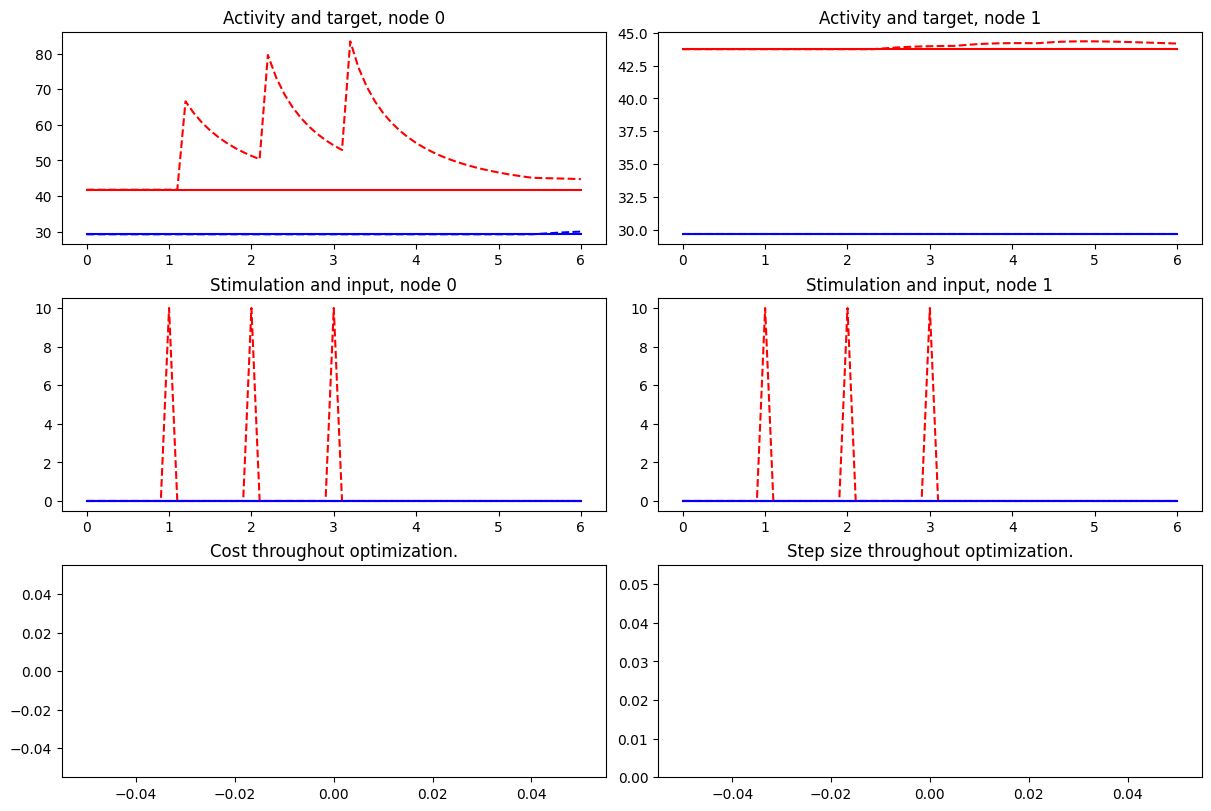

In [19]:
cmat = np.array( [[0., 0.], [1., 0.]] ) # diagonal elements are zero, connection strength is 1 from node 0 to node 1
dmat = np.array( [[0., 0.], [18, 0.]] ) # distance from 0 to 1, delay is computed by dividing by the signal speed params.signalV

model = ALNModel(Cmat=cmat, Dmat=dmat)

model.params.mue_ext_mean = 2. # up state
model.run()
setinitstate(model, getfinalstate(model))

duration = 6.
model.params.duration = duration
model.run()

# we define the control input matrix to enable or disable certain channels and nodes
control_mat = np.zeros( (model.params.N, len(model.state_vars)) )
control_mat[0,0] = 1. # only allow inputs in E-channel in node 0

zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = zero_input.copy()
input[0,10] = 10. 
input[0,20] = 10.
input[0,30] = 10. # Three pulses as control input

input_nw = np.concatenate( (np.vstack( [control_mat[0,0] * input, control_mat[0,1] * input, control_mat[0,2] * input, control_mat[0,3] * input] )[np.newaxis,:,:],
                            np.vstack( [control_mat[1,0] * input, control_mat[1,1] * input, control_mat[1,2] * input, control_mat[1,3] * input] )[np.newaxis,:,:]), axis=0)
zero_input_nw = np.concatenate( (np.vstack( [zero_input, zero_input, zero_input, zero_input] )[np.newaxis,:,:],
                                 np.vstack( [zero_input, zero_input, zero_input, zero_input] )[np.newaxis,:,:]), axis=0)

model.params["ext_exc_current"] = input_nw[:,0,:]
model.params["ext_inh_current"] = input_nw[:,1,:]
model.params["ext_exc_rate"] = input_nw[:,2,:]
model.params["ext_inh_rate"] = input_nw[:,3,:]
model.run()

# Define the result of the stimulation as target
target = getstate(model)

# Remove stimuli and re-run the simulation
model.params["ext_exc_current"] = zero_input_nw[:,0,:]
model.params["ext_inh_current"] = zero_input_nw[:,1,:]
model.params["ext_exc_rate"] = zero_input_nw[:,2,:]
model.params["ext_inh_rate"] = zero_input_nw[:,3,:]
model.run()

# combine initial value and simulation result to one array
state = getstate(model)
plot_oc_network(model.params.N, duration, dt, state, target, zero_input_nw, input_nw)

Compute control for a deterministic system
Cost in iteration 0: 0.359172941490044
Cost in iteration 25: 0.0009615468986463881
Cost in iteration 50: 0.0007333228165946963
Cost in iteration 75: 0.0006260013025462121
Cost in iteration 100: 0.0005505692558065825
Cost in iteration 125: 0.0004885428894743123
Cost in iteration 150: 0.00043735899230091054
Cost in iteration 175: 0.00039470273967215434
Cost in iteration 200: 0.0003557625136514394
Cost in iteration 225: 0.0003229079130967074
Cost in iteration 250: 0.0002955948773140632
Cost in iteration 275: 0.0002707181926108721
Cost in iteration 300: 0.00024812162228431687
Cost in iteration 325: 0.00022872532768374945
Cost in iteration 350: 0.00021139087531398977
Cost in iteration 375: 0.00019615161753377597
Cost in iteration 400: 0.00018255738033847666
Cost in iteration 425: 0.00017094218054607512
Cost in iteration 450: 0.00016024170703781454
Cost in iteration 475: 0.00015034465382819025
Cost in iteration 500: 0.0001420764272810447
Final cost 

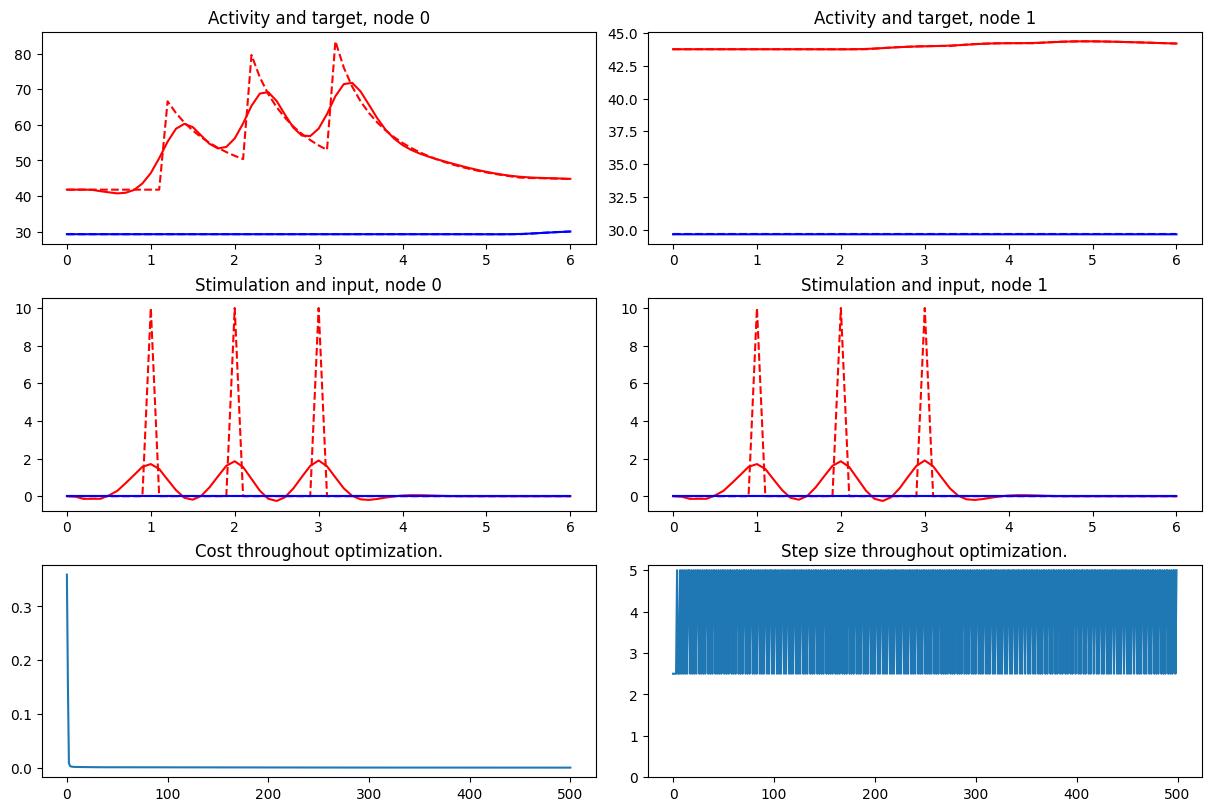

In [20]:
# We load the optimal control class
# print array (optional parameter) defines, for which iterations intermediate results will be printed
# Parameters will be taken from the input model
model.params["ext_exc_current"] = zero_input_nw[:,0,:]
model.params["ext_inh_current"] = zero_input_nw[:,1,:]
model.params["ext_exc_rate"] = zero_input_nw[:,2,:]
model.params["ext_inh_rate"] = zero_input_nw[:,3,:]
model_controlled = oc_aln.OcAln(model, target, print_array=np.arange(0,501,25), control_matrix=control_mat, cost_matrix=cost_mat)

# We run 500 iterations of the optimal control gradient descent algorithm
model_controlled.optimize(500)

state = model_controlled.get_xs()
control = model_controlled.control
plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)

Compute control for a deterministic system
Cost in iteration 0: 0.0001420764272810447
Cost in iteration 25: 0.0001344927174612406
Cost in iteration 50: 0.00012771251593868887
Cost in iteration 75: 0.00012171866153619686
Cost in iteration 100: 0.00011620280047727948
Final cost : 0.00011620280047727948


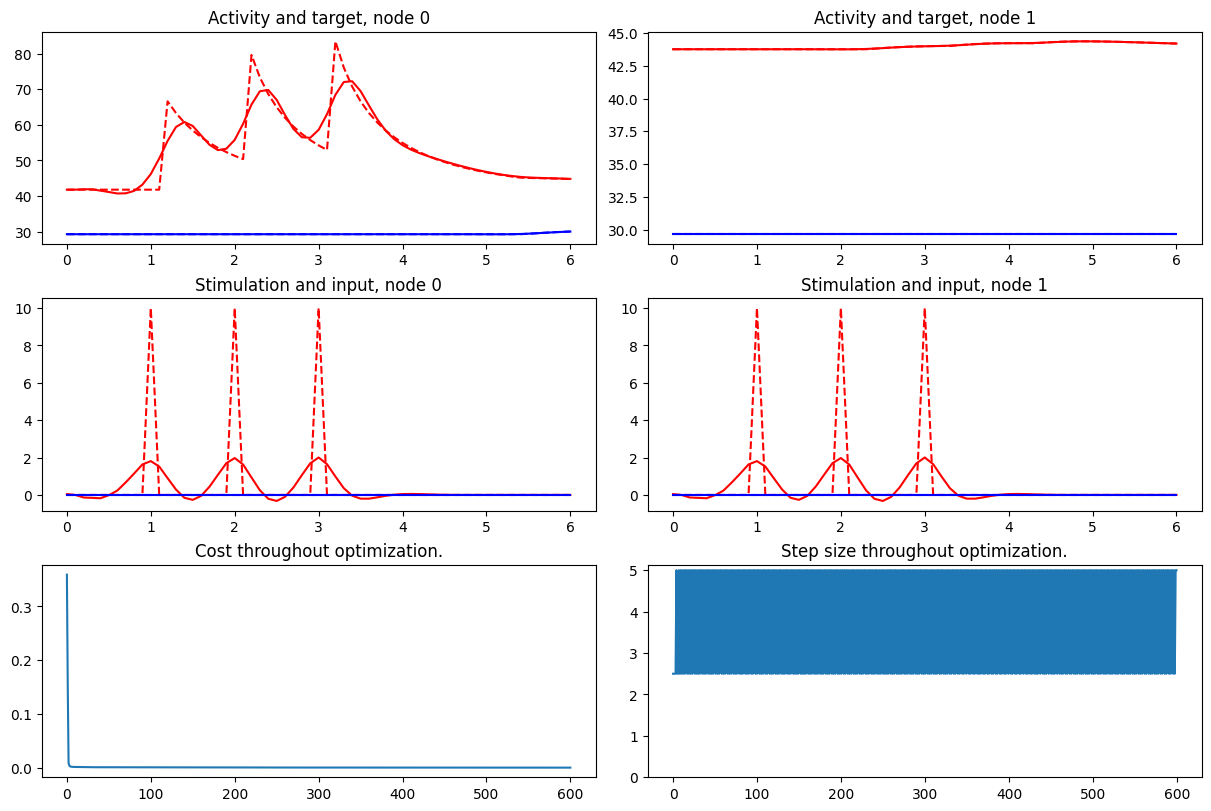

In [21]:
# perofrm another 100 iterations to improve result
# repeat execution to add another 100 iterations
# converence to the input stimulus is relatively slow for the WC nodel
model_controlled.optimize(100)
state = model_controlled.get_xs()
control = model_controlled.control
plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)